In [15]:
library(tidyverse)
library(infer)
library(gridExtra)

## Introduction

Stars are typically classified into four different groups – white dwarfs, main sequence, giants, and supergiants (Chiosi). The life cycle of a star depends on what type of star it is. A typical star will become a main sequence star and then end its lifecycle as a white dwarf. Main sequence stars account for around 90% of all stars in the universe (“Main Sequence Stars: Definition & Life Cycle.” ). Contrary to its name, red dwarfs are not a type of white dwarf. Rather they are a type of small main sequence star that is not very bright. Another type of dwarfs is a brown dwarf. These are not usually classified as stars because they do not burn hot enough (“Red Dwarfs: The Most Common and Longest-Lived Stars.”). White dwarfs are very small dense stars that are not very bright when compared to main sequence stars (Koester). When a massive star is formed it will become a giant star or a supergiant and then end its lifecycle as a neutron star or a blackhole. Giants and supergiants are very large stars (with supergiant being even larger) that shine very bright when compared to main sequence stars (Chiosi). 

In this project we want to determine if there is a difference in luminosity and temperature between red, brown, and white dwarfs. Our location parameter is the mean of luminosity and temperature and our scale parameter is the standard deviation of both luminosity and temperature.

The dataset that are using has the following variables

| Variable | Description |
| :-: | :-: |
| Absolute Temperature (K) | The temperature of the star in Kelvin |
| Relative Luminosity (L/Lo) | The luminosity of the star when divided by the average luminosity of the sun (3.828 x 10^26 Watts) |
| Relative Radius (R/Ro) | The radius of the star when divided by the average radius of the sun (6.9551 x 10^8 m) |
| Absolute Magnitude (Mv) | The absolute magnitude of the star |
| Star Color | The color of the star |
| Spectral Class (O,B,A,F,G,K,M) | If the star is a main sequence star, the type of main sequence star it is |
| Star Type (Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , SuperGiants, HyperGiants) | The type of star it is | 

In [2]:
# I changed the column names in my csv file to make them more manageable
# Temperature = T
# Luminosity = L
# Radius = R
# Absolute Magnitude = A_M
# Star Type = Type
# Star Color = Color
# Spectral Class = Spectral_class

stars <- read.csv("6-class.csv")

glimpse(stars)

Rows: 240
Columns: 7
$ Temperature..K.        <int> 3068, 3042, 2600, 2800, 1939, 2840, 2637, 2600,…
$ Luminosity.L.Lo.       <dbl> 0.002400, 0.000500, 0.000300, 0.000200, 0.00013…
$ Radius.R.Ro.           <dbl> 0.17000, 0.15420, 0.10200, 0.16000, 0.10300, 0.…
$ Absolute.magnitude.Mv. <dbl> 16.120, 16.600, 18.700, 16.650, 20.060, 16.980,…
$ Star.type              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,…
$ Star.color             <chr> "Red", "Red", "Red", "Red", "Red", "Red", "Red"…
$ Spectral.Class         <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M", "M…


In [3]:
stars <- mutate(stars, Star.type = as_factor(Star.type))

In [4]:
dwarfs <- stars %>%
filter(Star.type != 5) %>%
filter(Star.type != 4) %>%
filter(Star.type != 3)


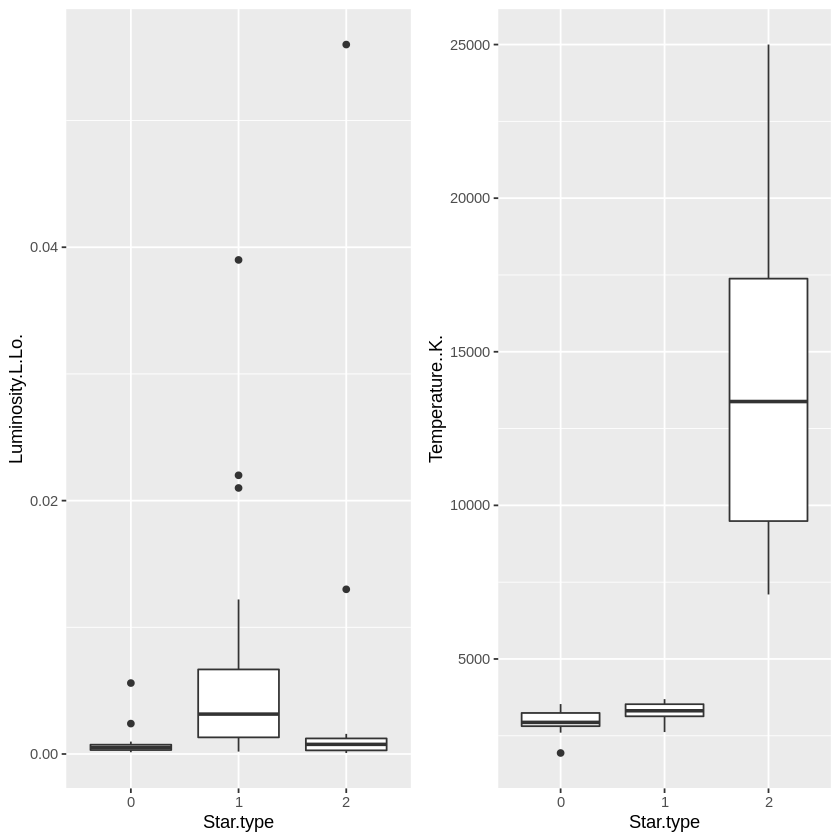

In [5]:
L_box <- ggplot(dwarfs, aes(x = Star.type, y = Luminosity.L.Lo.)) + geom_boxplot()
T_box <- ggplot(dwarfs, aes(x = Star.type, y = Temperature..K.)) + geom_boxplot()
grid.arrange(L_box, T_box, ncol=2)

#let's add a title here
#should we add comments to the code?

In [6]:
type_0 <- filter(stars, Star.type == 0)
type_1 <- filter(stars, Star.type == 1)
type_2 <- filter(stars, Star.type == 2)

### Brown Dwarf Distributions

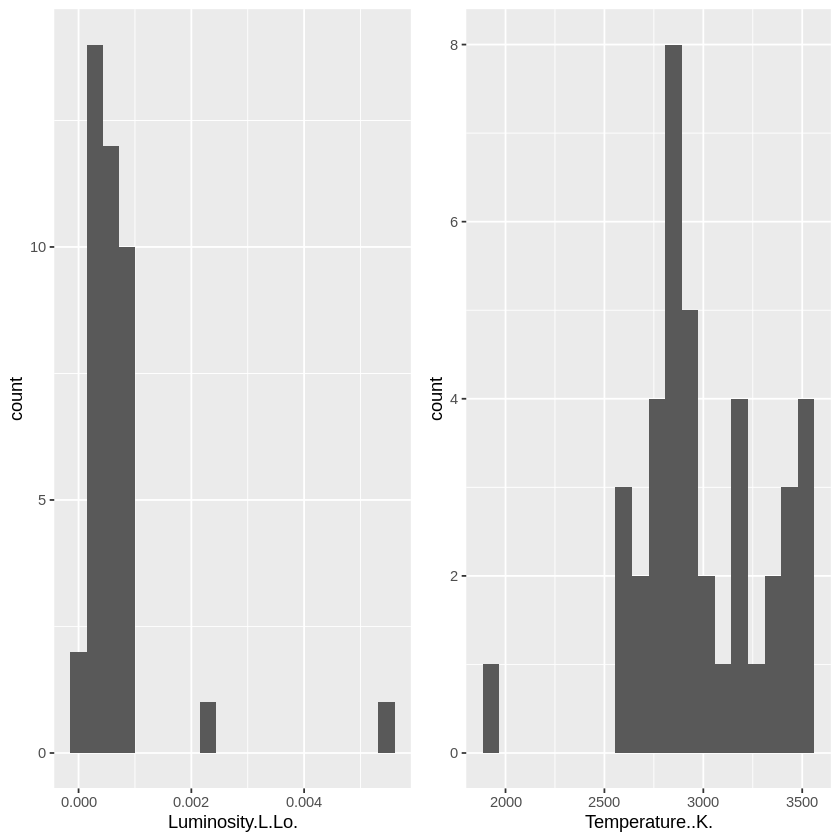

In [7]:
L_0 <- ggplot(type_0, aes(x = Luminosity.L.Lo.)) + geom_histogram(bins = 20)
T_0 <- ggplot(type_0, aes(x = Temperature..K.)) + geom_histogram(bins = 20)
grid.arrange(L_0, T_0, ncol=2)

### Red Dwarf Distributions

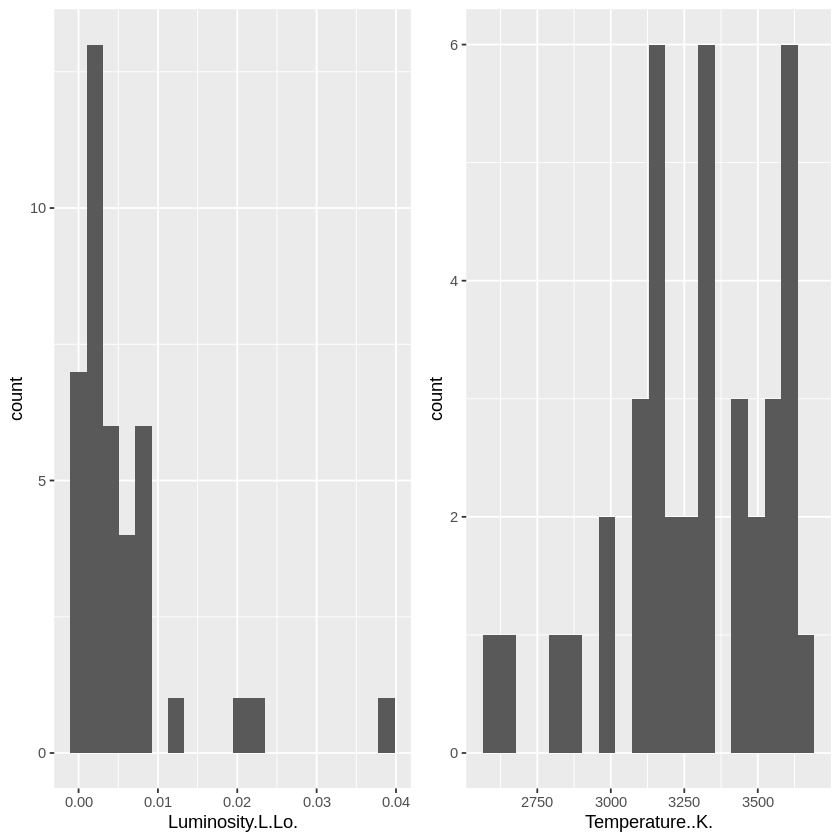

In [8]:
L_1 <- ggplot(type_1, aes(x = Luminosity.L.Lo.)) + geom_histogram(bins = 20)
T_1 <- ggplot(type_1, aes(x = Temperature..K.)) + geom_histogram(bins = 20)
grid.arrange(L_1, T_1, ncol=2)

### White Dwarf Distributions

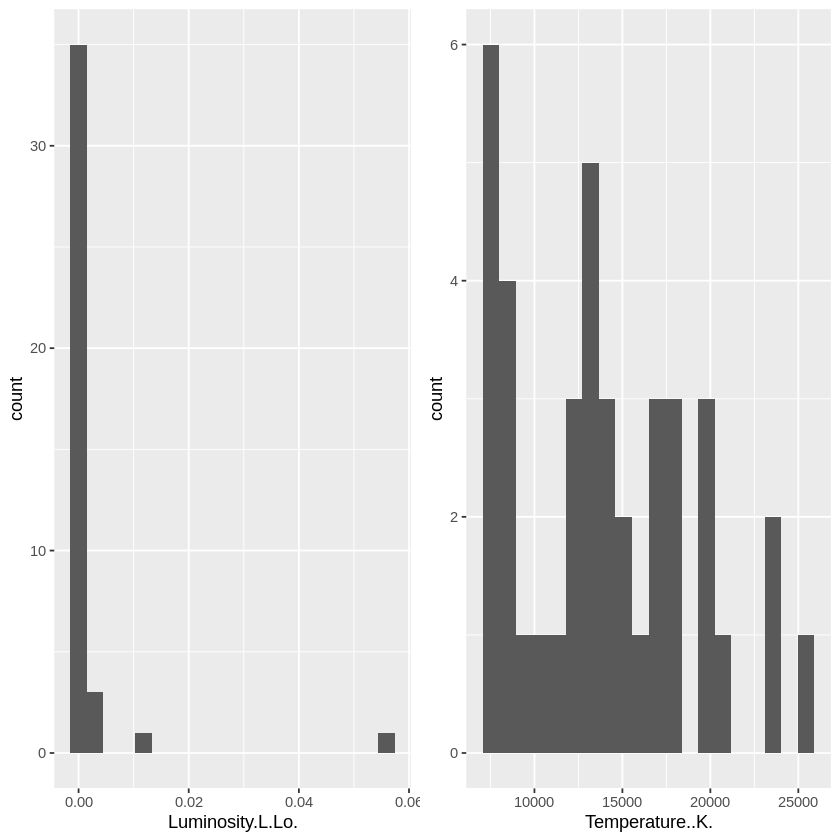

In [9]:
L_2 <- ggplot(type_2, aes(x = Luminosity.L.Lo.)) + geom_histogram(bins = 20)
T_2 <- ggplot(type_2, aes(x = Temperature..K.)) + geom_histogram(bins = 20)
grid.arrange(L_2, T_2, ncol=2)

In [72]:
#bootstrap 
brown_dwarf_stats <- type_0 %>% 
    rep_sample_n(size = 40, reps = 1000, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              mean_temp = mean(Temperature..K.),
              sd_lum = sd(Luminosity.L.Lo.),
              sd_temp = sd(Temperature..K.)) %>%
    summarise(mean_lum = mean(mean_lum), 
              mean_temp = mean(mean_temp), 
              SE_lum = sd(sd_lum), 
              SE_temp = sd(sd_temp)) %>%
    add_column(Type = "Brown", .before = "mean_lum")

red_dwarf_stats <- type_1 %>% 
    rep_sample_n(size = 40, reps = 1000, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              mean_temp = mean(Temperature..K.),
              sd_lum = sd(Luminosity.L.Lo.),
              sd_temp = sd(Temperature..K.)) %>%
    summarise(mean_lum = mean(mean_lum), 
              mean_temp = mean(mean_temp), 
              SE_lum = sd(sd_lum), 
              SE_temp = sd(sd_temp)) %>%
    add_column(Type = "Red", .before = "mean_lum")

white_dwarf_stats <- type_2 %>% 
    rep_sample_n(size = 40, reps = 1000, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              mean_temp = mean(Temperature..K.),
              sd_lum = sd(Luminosity.L.Lo.),
              sd_temp = sd(Temperature..K.)) %>%
    summarise(mean_lum = mean(mean_lum), 
              mean_temp = mean(mean_temp), 
              SE_lum = sd(sd_lum), 
              SE_temp = sd(sd_temp)) %>%
    add_column(Type = "White", .before = "mean_lum")

parameter_estimates <- rbind(brown_dwarf_stats, red_dwarf_stats, white_dwarf_stats)
parameter_estimates

Type,mean_lum,mean_temp,SE_lum,SE_temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Brown,0.0006923572,2998.673,0.0003632051,46.06350
Red,0.0053536705,3283.338,0.0020648776,28.80439
White,0.0024290709,13901.031,0.0046909233,462.46621


In [ ]:
brown_dwarf_stats <- type_0 %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              mean_temp = mean(Temperature..K.),
              sd_lum = sd(Luminosity.L.Lo.),
              sd_temp = sd(Temperature..K.)) %>%
    add_column(Type = "Brown", .before = "mean_lum")

red_dwarf_stats <- type_1 %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              mean_temp = mean(Temperature..K.),
              sd_lum = sd(Luminosity.L.Lo.),
              sd_temp = sd(Temperature..K.)) %>%
    add_column(Type = "Red", .before = "mean_lum")

white_dwarf_stats <- type_2 %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              mean_temp = mean(Temperature..K.),
              sd_lum = sd(Luminosity.L.Lo.),
              sd_temp = sd(Temperature..K.)) %>%
    add_column(Type = "White", .before = "mean_lum")

parameter_estimates <- rbind(brown_dwarf_stats, red_dwarf_stats, white_dwarf_stats)
parameter_estimates

## Methods: Plan

In the final report, we expect to find whether we are confident to say there is a difference in the luminosity and temperature between dwarf stars using statistical inferential techniques including hypothesis testing, ANOVA, etc. We will express our result and the uncertainty in a trustworthy way with the support of data analysis. 
We believe this finding clarifies the difference in some features (luminosity and temperature) between different types of dwarf stars, which improves people’s understanding, and further increases the accuracy and reliability of star classification.
It leads to the questions of other differences between dwarf stars such as “is there a difference in the magnitude between dwarf stars”, and how to apply the result in the real astronomical observation.


## Citation

Chiosi, Cesare, Gianpaolo Bertelli, and Alessandro Bressan. "New developments in understanding the HR diagram." Annual review of astronomy and astrophysics 30.1 (1992): 235-285.

Koester, Detlev, and Ganesar Chanmugam. "Physics of white dwarf stars." Reports on Progress in Physics 53.7 (1990): 837.
Tillman, Nola Taylor, and Ben Biggs. “Main Sequence Stars: Definition & Life Cycle.” Space.com, Space, 26 Jan. 2022, https://www.space.com/22437-main-sequence-star.html. 
Tillman, Nola Taylor. “Red Dwarfs: The Most Common and Longest-Lived Stars.” Space.com, Space, 6 June 2019, https://www.space.com/23772-red-dwarf-stars.html. 